<a href="https://colab.research.google.com/github/benayas1/vit-unet/blob/main/ViT_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements:

* ViT does not scalate, use Re-Attention instead of Self-Attention: https://arxiv.org/pdf/2103.11886.pdf
  * $ \text{Re-Attention}(Q,K,V)=\text{Norm}\left(\Phi^T\text{softmax}(\frac{Q\cdot K^T}{\sqrt{d}})\right)\cdot V $
  * The advantages of the proposed Re-attention are two-fold. First of all, compared with other possible attention augmentation methods, such as randomly dropping some elements of the attention map or tuning SoftMax temperature, our Re-attention exploits the interactions among different attention heads to collect their complementary information and better improves the attention map diversity.
  * Option 1: Re-Attention UNet.

* FNet: https://arxiv.org/abs/2105.03824
  * Option 2: F-UNet.


* Attention UNet paper: https://arxiv.org/pdf/1804.03999.pdf

* Uformer implementation: https://github.com/lucidrains/uformer-pytorch

* Official pancreas repo: https://wiki.cancerimagingarchive.net/display/Public/Pancreas-CT

* Unofficial: https://github.com/snapfinger/pancreas-seg

In [ ]:
import numpy as np
from typing import Tuple
import itertools
import torch
import matplotlib.pyplot as plt
from matplotlib import image
import urllib.request

In [ ]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.float
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

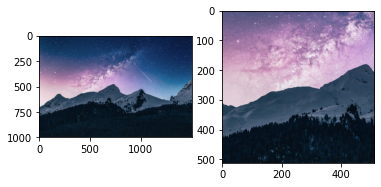

In [ ]:
URL = 'http://s557224138.onlinehome.us/wp-content/uploads/2020/05/1_MI686k5sDQrISBM6L8pf5A.jpeg'
with urllib.request.urlopen(URL) as url:
    with open('temp.jpeg', 'wb') as f:
        f.write(url.read())

img = image.imread('/content/temp.jpeg')
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(img)
image_size = 512
patch_size = 32
X = torch.as_tensor(img[300:300+image_size,250:250+image_size].reshape(1,image_size,image_size,3), dtype = torch.float)
fig.add_subplot(1, 2, 2)
plt.imshow(img[300:300+image_size,250:250+image_size])
X = X.permute((0,3,1,2))

# 1 - Preprocessing: Patches

In this section, we want our sample (1-size batch of images) to be extended in small patches.

In [ ]:
# AZM: Why do you include that "if" at the beginning?
# AB: because the first time this function is called, tensor has rank 4: bs, c, h, w
# AB: But the next times it is called, tensor has rank 5: bs, n_patches, c, h, w
# AB: the thing is that n_patches==1 when the image is fully reconstructed, so the sape would be bs, 1, c, h, w  and therefore the squeeze call
# AZM: Ok.
def Patch(X:torch.Tensor,
          patch_size:int):
    if len(X.size())==5:
        X = torch.squeeze(X, dim=1)
    h, w = X.shape[-2], X.shape[-1]
    assert h%patch_size==0, f"Patch size must divide images height"
    assert w%patch_size==0, f"Patch size must divide images width"
    patches = X.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patch_list = []
    for row, col in itertools.product(range(h//patch_size), range(w//patch_size)):
        patch_list.append(patches[:,:,row,col,:,:])
    patches = torch.stack(patch_list, dim = 1)
    return patches

Example: If we want our $512\times 512$ images to be patched in $128\times 128$ elements, the method will return a batch of 16 lists with $3\times 128\times128$ patches, where $3$ stands for the number of channels:

In [ ]:
patches = Patch(X, patch_size)
print(patches.shape)

torch.Size([1, 256, 3, 32, 32])


Image size: 512 X 512
Patches size: 32 X 32
Patches per image: 256
Pixels per patch: 3072


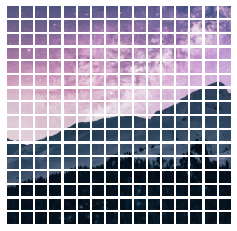

In [ ]:
print(f"Image size: {image_size} X {image_size}")
print(f"Patches size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Pixels per patch: {3*patch_size**2}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = patch.permute((1,2,0))
    plt.imshow(patch_img.cpu().numpy().astype("uint8"))
    plt.axis("off")

It will be very useful to be able to restore the original image form the patches:

In [ ]:
def Unflatten(flattened):
        # Alberto: Added to reconstruct from bs, n, projection_dim -> bs, n, c, h, w
        bs, n, p = flattened.size()
        unflattened = torch.reshape(flattened, (bs, n, 3, int(np.sqrt(p/3)), int(np.sqrt(p/3))))
        return unflattened

def Unpatch(x):
    if len(patches.size()) < 5:
        batch_size, num_patches, ch, h, w = Unflatten(patches).size()
    else:
        batch_size, num_patches, ch, h, w = patches.size()
    elem_per_axis = int(np.sqrt(num_patches))
    patches_middle = torch.cat([patch for patch in patches.reshape(batch_size,elem_per_axis,elem_per_axis,ch,h,w)[0]], dim = -2)
    restored_image = torch.cat([patch for patch in patches_middle], dim = -1).reshape(batch_size,1,ch,h*elem_per_axis,w*elem_per_axis)
    return restored_image

Example: Let's get out image back from patches list.

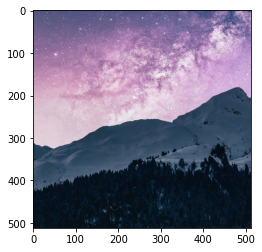

In [ ]:
restored_image = Unpatch(patches)
restored_image = restored_image[0,0,:,:,:].permute((1,2,0))
plt.imshow(restored_image.cpu().numpy().astype("uint8"))
plt.show()

After this reshape, it is time to add a positional encoding. To that end, we will:

1.   Flatten images.
2.   Adjust flattened images size ($3\cdot \text{patch_size}^2$) to a certain `projection_dim` parameter.
3.   Embed an enumeration of those patches to that `projection_dim`.

For this architecture, it will be required that `projection_dim` is equal to $3\cdot \text{patch_size}^2$.

Also, note that there will be a few downsamplings, therefore we will have to make a positional encoding detailed enough to capture that much granularity. For example, if we start with the previous patching, and apply downsampling twice, every time we split each patch in four pieces, and hence the minimum patch size in the architecture will be (writing $\text{n}_{\text{steps}}$ as the number of downsamplings): $$\frac{\text{patch_size}}{2^{\text{n}_{\text{steps}}}}$$



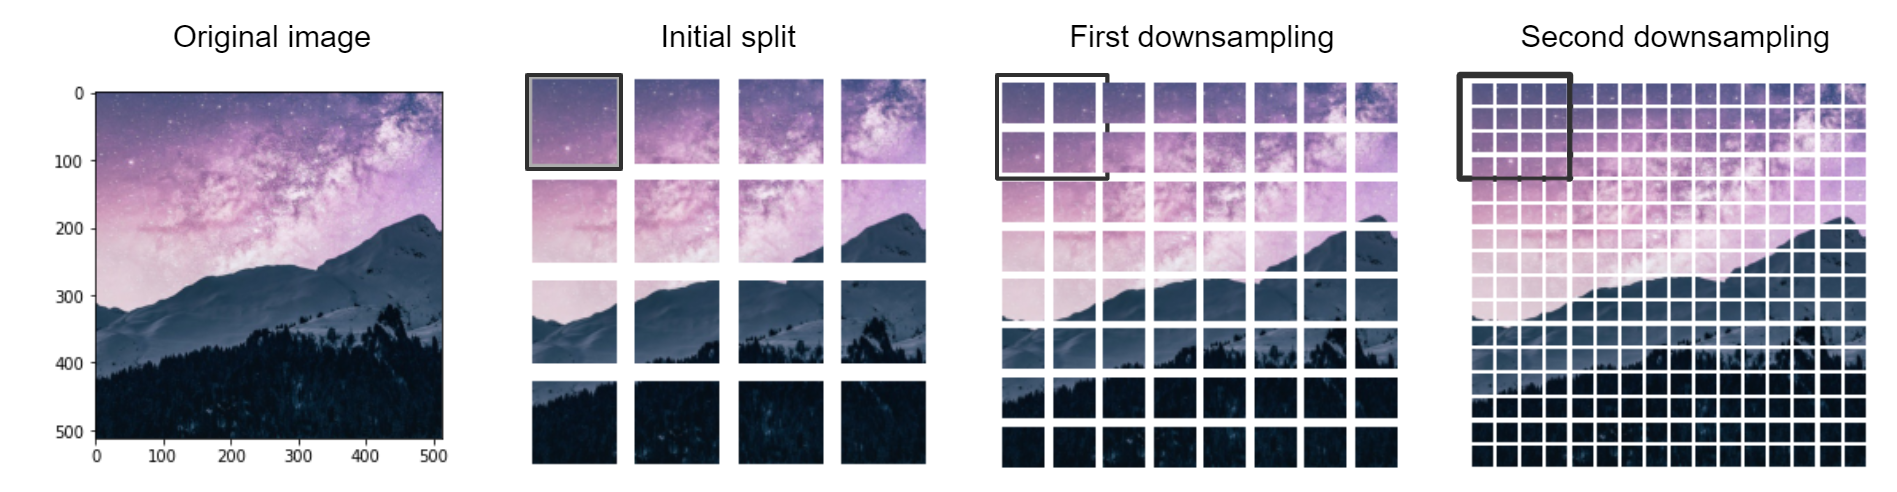

In [ ]:
class PatchEncoder(torch.nn.Module):
    def __init__(self,
                 depth:int,
                 num_patches:int,
                 patch_size:int,
                 preprocessing:str,
                 dtype:torch.dtype,
                 ):
        super(PatchEncoder, self).__init__()
        # Parameters
        self.depth = depth
        self.patch_size = patch_size
        self.patch_size_final = self.patch_size//(2**self.depth)
        self.num_patches = num_patches
        self.num_patches_final = self.num_patches*(4**self.depth)
        assert preprocessing in ['conv', 'fourier', 'none'], f"Preprocessing can only be 'conv', 'fourier' or 'none'."
        self.preprocessing = preprocessing
        self.dtype = dtype
        self.positions = torch.arange(start = 0,
                         end = self.num_patches_final,
                         step = 1,
                         )

        # Layers
        if self.preprocessing == "conv":
            self.conv2d = torch.nn.Conv2d(3, 3, 3, padding = 'same')
        self.position_embedding = torch.nn.Embedding(num_embeddings=self.num_patches_final,
                                                     embedding_dim = 3*self.patch_size_final**2,
                                                     )

    def forward(self, X):
        if self.preprocessing == 'conv':
            X = self.conv2d(X)
        elif self.preprocessing == 'fourier':
            X = torch.fft.fft2(X).real
        patches = Patch(X, self.patch_size_final)
        flat_patches = torch.flatten(patches, -3, -1)
        encoded = flat_patches + self.position_embedding(self.positions)
        encoded = torch.flatten(Patch(Unpatch(Unflatten(encoded)), patch_size = self.patch_size), -3, -1)
        return encoded

Example:

In [ ]:
num_patches = patches.shape[1]
print(f"Num patches = {num_patches} | Patch size {patch_size} | Projection Dim = {num_patches}")
enc_patch = PatchEncoder(depth = 1,
                         num_patches = num_patches,
                         patch_size = patch_size,
                         preprocessing = 'none',
                         dtype = torch.float, # Alberto: torch.double needs 8 bytes (64 bits) per value (too expensive). torch.float is normally a better option (4 bytes)
                         )
encoded_patches = enc_patch.forward(X)
print(encoded_patches.shape)

Num patches = 256 | Patch size 32 | Projection Dim = 256
torch.Size([1, 256, 3072])


# 2 - Transformer F-Encoder

## 2.1 - Architecture

The F-Encoder will process information based on discrete Fourier transform and linear operations, together with layer normalisations.

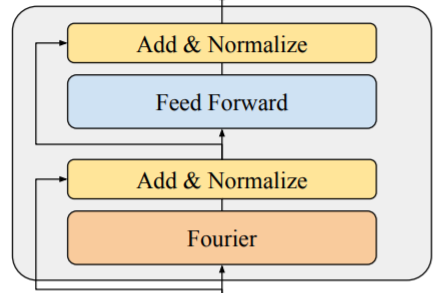

In [ ]:
class FeedForward(torch.nn.Module):
    def __init__(self,
                 projection_dim:int,
                 hidden_dim:int,
                 dropout:float,
                 dtype:torch.dtype,
                 ):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(projection_dim, hidden_dim, dtype = dtype),
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_dim, projection_dim, dtype = dtype),
            torch.nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

### 2.1.1 - Fourier method

In [ ]:
class FformerEncoder(torch.nn.Module):
    def __init__(self,
                 num_patches:int,
                 projection_dim:int,
                 hidden_dim:int,
                 dropout:float,
                 dtype:torch.dtype,
                 ):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.dtype = dtype
        self.LN = torch.nn.LayerNorm(normalized_shape = (self.num_patches, self.projection_dim),
                                     dtype = self.dtype,
                                     )
        self.FeedForward = FeedForward(projection_dim = self.projection_dim,
                                       hidden_dim = self.hidden_dim,
                                       dropout = self.dropout,
                                       dtype = self.dtype,
                                       )
    def forward(self, encoded_patches):
        encoded_patches += torch.fft.fft2(encoded_patches).real
        encoded_patches = self.LN(encoded_patches)
        encoded_patches += self.FeedForward(encoded_patches)
        encoded_patches = self.LN(encoded_patches)
        return encoded_patches

### 2.1.2 - ReAttention method

In [ ]:
class ReAttention(torch.nn.Module):
    """
    It is observed that similarity along same batch of data is extremely large. 
    Thus can reduce the bs dimension when calculating the attention map.
    """
    def __init__(self,
                 dim,
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop=0.,
                 proj_drop=0.,
                 expansion_ratio = 3,
                 apply_transform=True,
                 transform_scale=False,
                 ):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.apply_transform = apply_transform
        
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        if apply_transform:
            self.reatten_matrix = torch.nn.Conv2d(self.num_heads,self.num_heads, 1, 1)
            self.var_norm = torch.nn.BatchNorm2d(self.num_heads)
            self.qconv2d = torch.nn.Conv2d(3,3,1,padding = 'same', bias=qkv_bias)
            self.kconv2d = torch.nn.Conv2d(3,3,1,padding = 'same', bias=qkv_bias)
            self.vconv2d = torch.nn.Conv2d(3,3,1,padding = 'same', bias=qkv_bias)
            self.reatten_scale = self.scale if transform_scale else 1.0
        else:
            self.qconv2d = torch.nn.Conv2d(3,3,1,padding = 'same', bias=qkv_bias)
            self.kconv2d = torch.nn.Conv2d(3,3,1,padding = 'same', bias=qkv_bias)
            self.vconv2d = torch.nn.Conv2d(3,3,1,padding = 'same', bias=qkv_bias)
        
        self.attn_drop = torch.nn.Dropout(attn_drop)
        self.proj = torch.nn.Linear(dim, dim)
        self.proj_drop = torch.nn.Dropout(proj_drop)
    def forward(self, x, atten=None):
        B, N, C = x.shape
        q = torch.flatten(torch.stack([self.qconv2d(y) for y in Unflatten(x)], dim = 0), -3,-1)
        k = torch.flatten(torch.stack([self.kconv2d(y) for y in Unflatten(x)], dim = 0), -3,-1)
        v = torch.flatten(torch.stack([self.vconv2d(y) for y in Unflatten(x)], dim = 0), -3,-1)
        qkv = torch.cat([q,k,v], dim = -1).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)
        attn = (torch.matmul(q, k.transpose(-2, -1))) * self.scale
        attn = torch.nn.functional.softmax(attn, dim = -1)
        attn = self.attn_drop(attn)
        if self.apply_transform:
            attn = self.var_norm(self.reatten_matrix(attn)) * self.reatten_scale
        attn_next = attn
        x = (torch.matmul(attn, v)).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn_next

In [ ]:
#TO-DO: Use attention mask and explore configuration
class ReAttentionTransformerEncoder(torch.nn.Module):
    def __init__(self,
                 num_patches:int,
                 projection_dim:int,
                 hidden_dim:int,
                 num_heads:int,
                 attn_drop:int,
                 proj_drop:int,
                 linear_drop:float,
                 dtype:torch.dtype,
                 ):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.attn_drop = attn_drop
        self.proj_drop = proj_drop
        self.linear_drop = linear_drop
        self.dtype = dtype
        self.ReAttn = ReAttention(self.projection_dim,
                                  num_heads = self.num_heads,
                                  attn_drop = self.attn_drop,
                                  proj_drop = self.proj_drop,
                                  )
        self.LN = torch.nn.LayerNorm(normalized_shape = (self.num_patches, self.projection_dim),
                                     dtype = self.dtype,
                                     )
        self.FeedForward = FeedForward(projection_dim = self.projection_dim,
                                       hidden_dim = self.hidden_dim,
                                       dropout = self.linear_drop,
                                       dtype = self.dtype,
                                       )
    def forward(self, encoded_patches):
        encoded_patch_attn, attn_mask = self.ReAttn(encoded_patches)
        encoded_patches += encoded_patch_attn
        encoded_patches = self.LN(encoded_patches)
        encoded_patches += self.FeedForward(encoded_patches)
        encoded_patches = self.LN(encoded_patches)
        return encoded_patches

## 2.2 - DownSampling

One of the cornerstones in this work is how to perform downsampling, since we have flattened our image. This novel idea suggest to rebuild the patches, and split them in four other patches, in such a way that the number of patches is multiplied by four every iteration, and the size of the patches reduced by half on each axis:

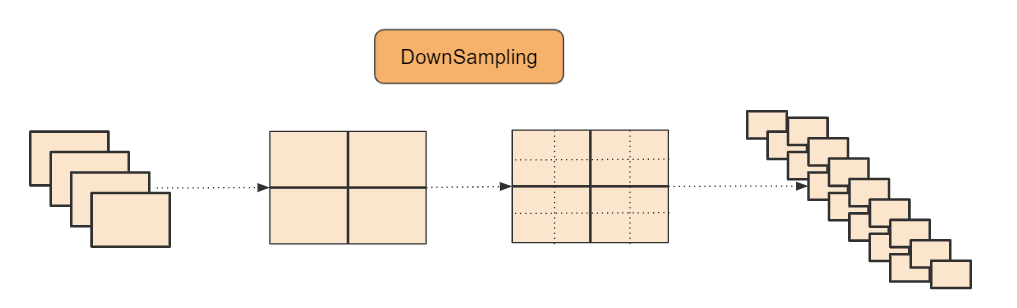

In [ ]:
def DownSampling(encoded_patches):
    #batch_size, num_patches, ch, h, w = encoded_patches.size() # Alberto: Encoded patches are no longer rank 5. Now they are rank 3, because the flatten layer merged the last 3 dimensions
    batch_size, num_patches, embeddings = encoded_patches.size()
    ch, h, w = 3, int(np.sqrt(embeddings/3)), int(np.sqrt(embeddings/3))
    original_image = Unpatch(Unflatten(encoded_patches))
    new_patches = Patch(original_image, patch_size = h//2)
    new_patches_flattened = torch.nn.Flatten(start_dim = -3, end_dim = -1).forward(new_patches)
    return new_patches_flattened

In [ ]:
print("Encoded patches shape:",encoded_patches.size())
print("Downsampled encoded patches shape:",DownSampling(encoded_patches).size())

Encoded patches shape: torch.Size([1, 256, 3072])
Downsampled encoded patches shape: torch.Size([1, 1024, 768])


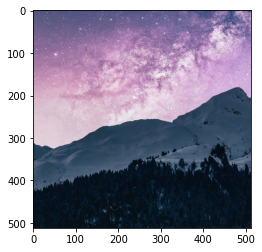

In [ ]:
# testing again that restoring works with even smaller patches
restored_image = Unpatch(Unflatten(DownSampling(encoded_patches)))
restored_image = restored_image[0,0,:,:,:].permute((1,2,0))
plt.imshow(restored_image.numpy().astype("uint8"))
plt.show()

## 2.3 - UpSampling

Similarly, one can think of the reverse process:

In [ ]:
def UpSampling(encoded_patches):
    #batch_size, num_patches, ch, h, w = encoded_patches.size() # Alberto: Encoded patches are no longer rank 5. Now they are rank 3, because the flatten layer merged the last 3 dimensions
    batch_size, num_patches, embeddings = encoded_patches.size()
    ch, h, w = 3, int(np.sqrt(embeddings/3)), int(np.sqrt(embeddings/3))
    original_image = Unpatch(Unflatten(encoded_patches))
    new_patches = Patch(original_image, patch_size = h*2)
    new_patches_flattened = torch.nn.Flatten(start_dim = -3, end_dim = -1).forward(new_patches)
    return new_patches_flattened

In [ ]:
print("Encoded patches shape:",encoded_patches.size())
print("Upsampled encoded patches shape:",UpSampling(encoded_patches).shape)

Encoded patches shape: torch.Size([1, 256, 3072])
Upsampled encoded patches shape: torch.Size([1, 64, 12288])


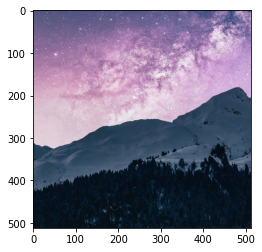

In [ ]:
# testing again that restoring works with even bigger patches
restored_image = Unpatch(Unflatten(UpSampling(encoded_patches)))
restored_image = restored_image[0,0,:,:,:].permute((1,2,0))
plt.imshow(restored_image.numpy().astype("uint8"))
plt.show()

## 2.4 - Skip Connections

Skip connections can also be implemented patch-wise at correlative levels via standard Badhanau attention.

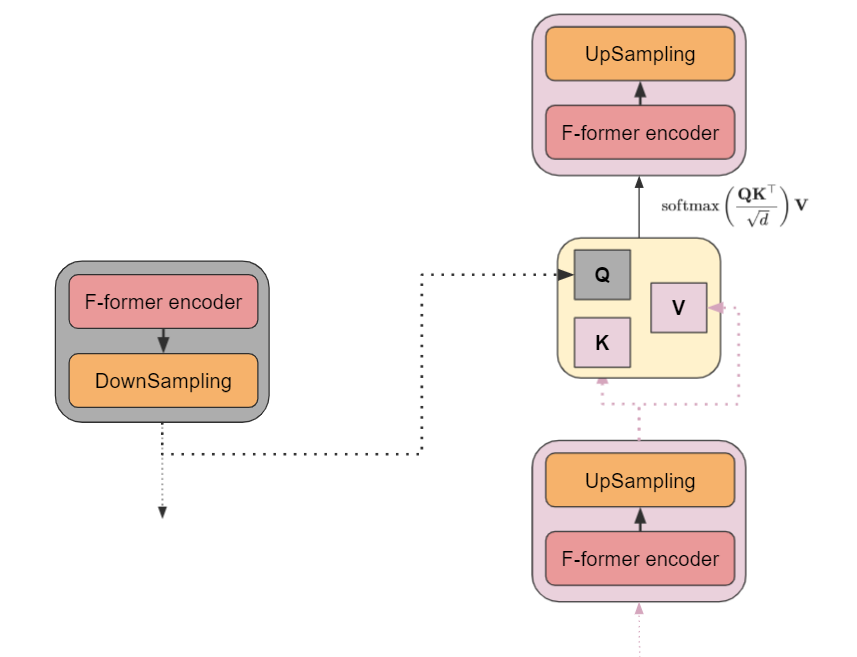

In [ ]:
class SkipConnection(torch.nn.Module):
    """
    It is observed that similarity along same batch of data is extremely large. 
    Thus can reduce the bs dimension when calculating the attention map.
    """
    def __init__(self,
                 dim,
                 num_heads=8,
                 qkv_bias=False,
                 attn_drop=0.,
                 proj_drop=0.,
                 transform_scale=False,
                 ):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = head_dim ** -0.5
        self.reatten_matrix = torch.nn.Conv2d(self.num_heads,self.num_heads, 1, 1)
        self.var_norm = torch.nn.BatchNorm2d(self.num_heads)
        self.qconv2d = torch.nn.Conv2d(3,3,1,padding = 'same', bias=qkv_bias)
        self.kconv2d = torch.nn.Conv2d(3,3,1,padding = 'same', bias=qkv_bias)
        self.vconv2d = torch.nn.Conv2d(3,3,1,padding = 'same', bias=qkv_bias)

        self.reatten_scale = self.scale if transform_scale else 1.0
        self.attn_drop = torch.nn.Dropout(attn_drop)
        self.proj = torch.nn.Linear(dim, dim)
        self.proj_drop = torch.nn.Dropout(proj_drop)
        

    def forward(self, q, k, v):
        assert q.shape==k.shape
        assert k.shape==v.shape
        B, N, C = q.shape
        q = torch.flatten(torch.stack([self.qconv2d(y) for y in Unflatten(q)], dim = 0), -3,-1)
        k = torch.flatten(torch.stack([self.kconv2d(y) for y in Unflatten(k)], dim = 0), -3,-1)
        v = torch.flatten(torch.stack([self.vconv2d(y) for y in Unflatten(v)], dim = 0), -3,-1)
        qkv = torch.cat([q,k,v], dim = -1).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)
        attn = (torch.matmul(q,k.transpose(-2, -1))) * self.scale
        attn = torch.nn.functional.softmax(attn, dim = -1)
        attn = self.attn_drop(attn)
        attn = self.var_norm(self.reatten_matrix(attn)) * self.reatten_scale

        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

# 3 - ViT-UNet

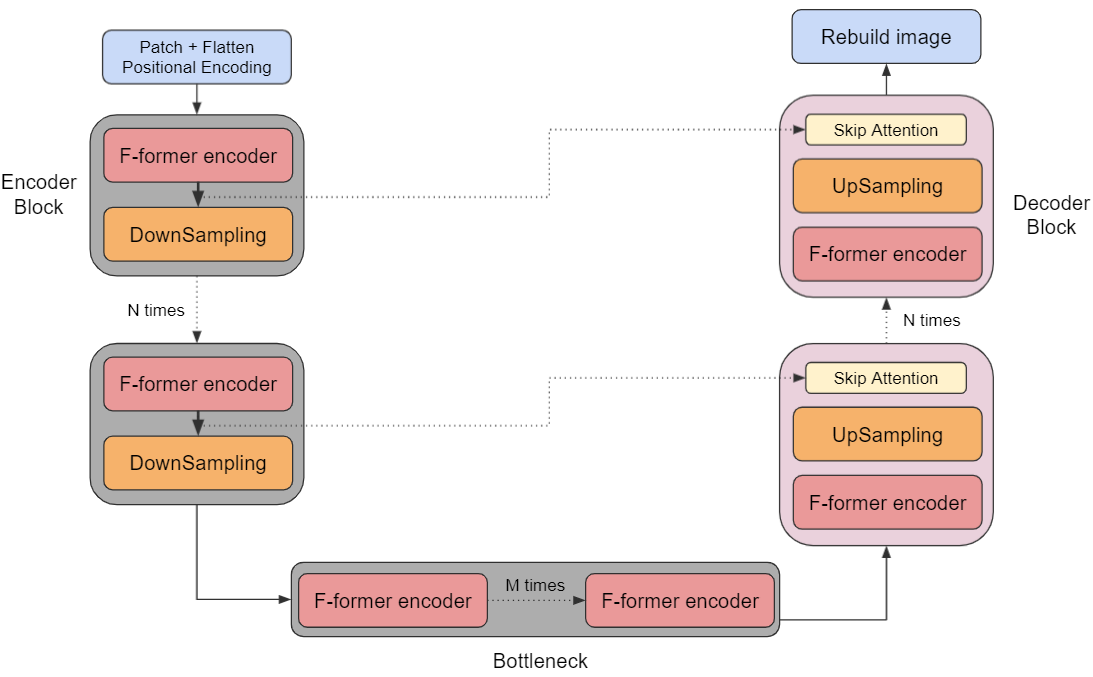

In [ ]:
class ViT_UNet(torch.nn.Module):
    def __init__(self,
                 depth:int,
                 depth_te:int,
                 size_bottleneck:int,
                 preprocessing:str,
                 num_patches:int,
                 patch_size:int,
                 projection_dim:int,
                 hidden_dim:int,
                 num_heads:int,
                 attn_drop:int,
                 proj_drop:int,
                 linear_drop:float,
                 dtype:torch.dtype,
                 ):
        super().__init__()
        # Testing
        assert patch_size%(2**(depth))==0, f"Depth must be adjusted, final patch size is incompatible."
        assert patch_size//(2**(depth))>=4, f"Depth must be adjusted, final patch size is too small (lower than 4)."
        print('Architecture information:')
        for i in range(depth+1):
            print('Level {}:'.format(i))
            print('\tPatch size:',patch_size//(2**i))
            print('\tNum. patches:',num_patches*(4**i))
            print('\tProjection size:',projection_dim//(4**i))
            print('\tHidden dim. size:',hidden_dim//(2**i))
        # Parameters
        self.depth = depth
        self.depth_te = depth_te
        self.size_bottleneck = size_bottleneck
        self.preprocessing = preprocessing
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.attn_drop = attn_drop
        self.proj_drop = proj_drop
        self.linear_drop = linear_drop
        self.dtype = dtype
        # Layers
        self.PE = PatchEncoder(self.depth,self.num_patches,self.patch_size,self.preprocessing,self.dtype)
        self.Encoders = torch.nn.ModuleList()
        for level in range(self.depth):
            exp_factor = 4**(level)
            exp_factor_hidden = 2**(level)
            for _ in range(depth_te):
                self.Encoders.append(
                    ReAttentionTransformerEncoder(self.num_patches*exp_factor,
                                                  self.projection_dim//exp_factor,
                                                  self.hidden_dim//exp_factor_hidden,
                                                  self.num_heads,
                                                  self.attn_drop,
                                                  self.proj_drop,
                                                  self.linear_drop,
                                                  self.dtype,
                                                  )
                )
        self.BottleNeck = torch.nn.ModuleList()
        for _ in range(self.size_bottleneck):
            exp_factor = 4**(self.depth)
            exp_factor_hidden = 2**(self.depth)
            self.BottleNeck.append(
                ReAttentionTransformerEncoder(self.num_patches*exp_factor,
                                              self.projection_dim//exp_factor,
                                              self.hidden_dim//exp_factor_hidden,
                                              self.num_heads,
                                              self.attn_drop,
                                              self.proj_drop,
                                              self.linear_drop,
                                              self.dtype,
                                              )
            )
        self.Decoders = torch.nn.ModuleList()
        self.SkipConnections = torch.nn.ModuleList()
        for level in range(self.depth):
            exp_factor = 4**(self.depth-level)
            exp_factor_skip = 4**(self.depth-level-1)
            exp_factor_hidden = 2**(self.depth-level)
            for _ in range(depth_te):
                self.Decoders.append(
                    ReAttentionTransformerEncoder(self.num_patches*exp_factor,
                                                  self.projection_dim//exp_factor,
                                                  self.hidden_dim//exp_factor_hidden,
                                                  self.num_heads,
                                                  self.attn_drop,
                                                  self.proj_drop,
                                                  self.linear_drop,
                                                  self.dtype,
                                                  )
                )
            self.SkipConnections.append(
                SkipConnection(dim = self.projection_dim//exp_factor_skip,
                               num_heads = self.num_heads,
                               attn_drop = self.attn_drop,
                               proj_drop = self.proj_drop,
                               )
                )
        
        # Output
        if self.preprocessing == 'conv':
            self.conv2d = torch.nn.Conv2d(3,3,3,padding = 'same')
    
    def forward(self,
                X:torch.Tensor,
                ):
        # Previous validations
        batch_size, ch, h, w = X.size()

        # "Preprocessing"
        X_patch = self.PE(X)

        # Encoders
        encoder_skip = []
        print('Start encoding. Original shape:',X_patch.size())
        for i, enc in enumerate(self.Encoders):
            X_patch = enc(X_patch)
            if (i+1)%self.depth_te==0:
                encoder_skip.append(X_patch)
                X_patch = DownSampling(X_patch)
                print("\t Shape after level " + str((i+1)//self.depth_te) + " of encoding:",X_patch.size())
        # Bottleneck
        print('Start bottleneck')
        for i, bottle in enumerate(self.BottleNeck):
            X_patch = bottle(X_patch)
            print("\t Shape after step " + str(i+1) + " of bottleneck:",X_patch.size())
        # Decoders
        print('Start decoding')
        for i, dec in enumerate(self.Decoders):
            print('\tStep',i+1)
            X_patch = dec(X_patch)
            if (i+1)%self.depth_te==0:
                X_patch = UpSampling(X_patch)
                print("\t Shape after level " + str((i+1)//self.depth_te) + " of decoding:",X_patch.size())
                print('\tSkip connection')
                assert encoder_skip[self.depth-((i+1)//self.depth_te)].shape==X_patch.shape, f"enc and dec not same shape"
                X_patch = self.SkipConnections[(i-1)//self.depth_te](encoder_skip[self.depth-((i+1)//self.depth_te)], X_patch, X_patch)
        
        # Output
        X_restored = Unpatch(Unflatten(X_patch)).reshape(batch_size, ch, h, w)
        print('Final processing is: ' + self.preprocessing)
        if self.preprocessing == 'conv':
            X_restored = self.conv2d(X_restored)
        elif self.preprocessing == 'fourier':
            X_restored = torch.fft.ifft2(X, norm='ortho').real

        return X_restored

In [ ]:
ViT_model = ViT_UNet(depth = 2,
                     depth_te = 2,
                    size_bottleneck = 1,
                    preprocessing = 'conv',
                    num_patches = 256,
                    patch_size = 32,
                    projection_dim = 3*32*32,
                    hidden_dim = 256,
                    num_heads = 8,
                    attn_drop = .2,
                    proj_drop = .2,
                    linear_drop = 0,
                    dtype = torch.float32,
                    )
# Device
#ViT_model.to(device)

Architecture information:
Level 0:
	Patch size: 32
	Num. patches: 256
	Projection size: 3072
	Hidden dim. size: 256
Level 1:
	Patch size: 16
	Num. patches: 1024
	Projection size: 768
	Hidden dim. size: 128
Level 2:
	Patch size: 8
	Num. patches: 4096
	Projection size: 192
	Hidden dim. size: 64


In [ ]:
sum([p.numel() for p in ViT_model.parameters()])

50345433

In [ ]:
ViT_model.forward(X).size()

Start encoding. Original shape: torch.Size([1, 256, 3072])
	 Shape after level 1 of encoding: torch.Size([1, 1024, 768])
	 Shape after level 2 of encoding: torch.Size([1, 4096, 192])
Start bottleneck
	 Shape after step 1 of bottleneck: torch.Size([1, 4096, 192])
Start decoding
	Step 1
	Step 2
	 Shape after level 1 of decoding: torch.Size([1, 1024, 768])
	Skip connection
	Step 3
	Step 4
	 Shape after level 2 of decoding: torch.Size([1, 256, 3072])
	Skip connection
Final processing is: conv


torch.Size([1, 3, 512, 512])